In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as smp
from tqdm import tqdm
from sympy import Symbol, symbols
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from julia import Main

### Papermill parameters

In [2]:
Γ = 2*np.pi*1.56e6

transition_type = "R"
ground_J = 1
excited_F = 2
excited_F1 = 3/2
system_J = [1,3]

laser_power = 23.8e-3 # power in W
σlaser = 0.000914
npasses = 9
multipass_offset = 0.01
distance_between_passes = 0.03556/npasses
power_loss_per_pass = 20.2/23.8

vcm = 150
vcm_sigma = 30
vperp_sigma = 38

ωp = 0.65*Γ

β = 3.8
ωphase = 0.0

scan_range = [-30,31,2]

nprocs = 7

In [3]:
# Parameters
transition_type = "R"
excited_J = 2
excited_F = 3
excited_F1 = 2.5
system_Js = [1, 3]


In [4]:
trans = centrex.transitions.LaserTransition(
    f"{transition_type}{ground_J}",
    F1 = excited_F1,
    F = excited_F
)
population_J = trans.ground_selector.J

In [5]:
excited_state = centrex.states.QuantumSelector(
                    J=excited_J, F=excited_F, F1=excited_F1, 
                    electronic = 'B', P = trans.excited_selector.P
)
population_states = centrex.states.QuantumSelector(J=population_J, electronic = 'X')

print(f"excited state : {excited_state}")
print(f"population in states : {population_states}")

excited state : QuantumSelector(J=2, F1=2.5, F=3, mF=None, electronic='B', P=1, Ω=None)
population in states : QuantumSelector(J=1, F1=None, F=None, mF=None, electronic='X', P=None, Ω=None)


# Initial setup
## Involved states

In [6]:
gnd = centrex.states.QuantumSelector(J=system_J, electronic = 'X')
exc = excited_state

gnd_laser = centrex.states.QuantumSelector(J=trans.ground_selector.J, electronic = 'X')
exc_laser = excited_state

In [7]:
syspars = centrex.states.SystemParameters(
    nprocs  = nprocs,
    Γ       = Γ,
    X  = gnd,
    B = [exc]
)

## Parameters

In [8]:
odepars = centrex.lindblad.odeParameters(
    Ωl = "Ωl0 * phase_modulation(t, β, ωphase) * multipass_2d_intensity(vz*t, y0+vy*t, ampl, xlocs, ylocs, σzlaser, σylaser)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δl      = 0.0,              # detuning of the laser [rad/s]
    
    # laser beam properties
    σzlaser = σlaser * np.sqrt(2),
    σylaser = σlaser * np.sqrt(2),
    
    # laser multipass
    ampl = [np.sqrt(power_loss_per_pass**n) for n in range(npasses)],
    xlocs = [(n-1)*distance_between_passes + multipass_offset for n in centrex.utils.light.multipass_prism_order(npasses)],
    ylocs = npasses*[0.0],
    
    # laser phase modulation
    ωphase = ωphase,       # laser phase modulation frequency [rad/s]
    β      = β,             # laser phase modulation depth [rad]

    # laser polarization switching
    ωp = ωp,           # polarization switching frequency [rad/s]
    φp = 0.0,                 # polarization switching phase [rad]
    Pl  = "sin(ωp*t + φp)",
    Plz = "Pl>0",
    Plx = "Pl<=0",
    Ply = 0.0,
    
    # molecules
    y0 = 0.,                   # molecule start y position [m]
    vz = 150.,                 # longitudinal molecular velocity [m/s]
    vy = 0.,                   # molecule vy [m/s]
)


## Transitions

In [9]:
transitions = [
    centrex.couplings.TransitionSelector(
        ground = 1*centrex.states.generate_coupled_states_ground_X(gnd_laser),
        excited = 1*centrex.states.generate_coupled_states_excited_B(exc_laser),
        polarizations        = [[0,0,1],[1,0,0],[0,1,0]],
        polarization_symbols = symbols("Plz     Plx     Ply"),
        Ω = smp.Symbol('Ωl', complex = True),
        δ = smp.Symbol('δl'),
        description = "laser transition",        
    ),
]

In [10]:
transition_name = centrex.transitions.identify_transition(
    transitions[0].ground[0],
    transitions[0].excited[0]
)
transition_name = transition_name.replace(",","").replace("/","_")
transition_name

"R(1) F1'=5_2 F'=3"

## Generate System

In [11]:
%%time
obe_system = centrex.lindblad.setup_OBE_system_julia(syspars, odepars, transitions, verbose=True, full_output=True, 
                                                     qn_compact=centrex.states.QuantumSelector(J=3, electronic = 'X'))

[21:32:21] INFO     generate_OBE_system: 1/6 -> Generating the reduced      ]8;id=558193;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=49468;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#88\88]8;;\
                    Hamiltonian

[21:32:29] INFO     generate_OBE_system: 2/6 -> Generating the couplings   ]8;id=130101;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=665754;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#103\103]8;;\
                    corresponding to the transitions

[21:34:07] INFO     generate_OBE_system: 3/6 -> Generating the symbolic    ]8;id=911550;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=226256;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#138\138]8;;\
                    Hamiltonian

[21:34:23] INFO     generate_OBE_system: 4/6 -> Generating the collapse    ]8;id=320743;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=91786;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#149\149]8;;\
                    matrices

           INFO     generate_OBE_system: 5/6 -> Transforming the           ]8;id=503046;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=417196;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#178\178]8;;\
                    Hamiltonian and collapse matrices into a symbolic                        
                    system of equations

[21:34:25] INFO     generate_OBE_system: 6/6 -> Generating Julia code      ]8;id=720551;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=455798;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#186\186]8;;\
                    representing the system of equations

[21:34:33] INFO     setup_OBE_system_julia: 1/3 -> Generating the preamble ]8;id=767505;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=140668;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#266\266]8;;\

           INFO     setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 ]8;id=770037;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=310683;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#270\270]8;;\
                    cores

Initialized Julia with 7 processes


[21:35:04] INFO     setup_OBE_system_julia: 3/3 -> Defining the ODE        ]8;id=606874;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=553245;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#277\277]8;;\
                    equation and parameters in Julia

Wall time: 2min 43s


# Simulations
## Single trajectory

In [12]:
Ωl0 = centrex.utils.light.calculate_rabi_from_power_gaussian_beam(
                        laser_power,
                        obe_system.couplings[0]['main coupling'],
                        σlaser,
                        σlaser
    ).real
print(f"Ωl0 : {Ωl0 / syspars.Γ:.2f} Γ")

Ωl0 : 1.99 Γ


In [13]:
odepars.Ωl0 = Ωl0
odepars.ωphase = ωphase
odepars.ωp = ωp

In [14]:
ρ = centrex.utils.generate_population_states(population_states.get_indices(obe_system.QN), len(obe_system.QN))
t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,50e-3/odepars.vz+10e-6), ρ)

In [15]:
multipass = np.abs(odepars.get_parameter_evolution(t_array, "Ωl").real)

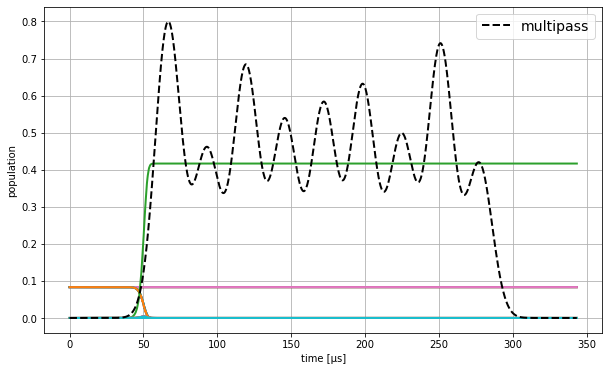

In [16]:
fig, ax = plt.subplots(figsize = (10,6)) 
ax.plot(t_array*1e6, results.T, lw = 2);
ax.plot(t_array*1e6, multipass/multipass.max()*0.8, 'k--', lw = 2,
        label = 'multipass')
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
ax.grid(True)

In [17]:
for states in np.array(obe_system.QN)[results[:,-1] > 0.05]:
    print(states.find_largest_component())

|X, J = 1, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 1, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
|X, J = 3, F₁ = None, F = None, mF = None, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


In [18]:
np.trapz(results[exc.get_indices(obe_system.QN),:].sum(axis = 0), t_array)*syspars.Γ

0.8758973440507162

## Detuning Scan

In [19]:
%%time

odepars.Ωl0 = Ωl0
odepars.ωphase = ωphase
odepars.ωp = ωp

tspan = (0,1000e-6)
ρ = centrex.utils.generate_population_states(
        centrex.states.QuantumSelector(J=1, F=[1,2], electronic = 'X').get_indices(obe_system.QN), 
        len(obe_system.QN)
    )

δl_scan = np.linspace(-5,5,101)*syspars.Γ

parameters = ["δl"]
values = [δl_scan]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 50e-3")

ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                        odepars, tspan, ρ, parameters, values, 
                        dimensions = 1,
                        output_func = output_func,
                        zipped = True
            )

centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                             callback = cb)

Wall time: 20.6 s


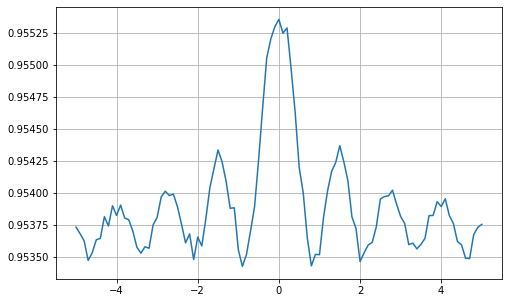

In [20]:
results = centrex.lindblad.get_results_parameter_scan()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan/syspars.Γ, results, '-')
ax.grid(True)

## Trajectory Scan

In [21]:
ntrajectories = 500

n = int(1e7)
vz = centrex.utils.generate_random_longitudinal_velocities(n, vcm, vcm_sigma)
vx, vy = centrex.utils.generate_random_transverse_velocities(n, vperp_sigma)
x0, y0 = centrex.utils.generate_random_coords_circle_2D(n, 0.0025)
apertures = [(47e-3, 6.35e-3), (73e-3, 12.7e-3), (290e-3, 2.54e-3)]
mask = np.ones(n, dtype = bool)
for (location, diameter) in apertures:
    t = location / vz
    r = np.sqrt((x0+vx*t)**2 + (y0+vy*t)**2)
    m = r < diameter/2
    mask &= m
    
start_loc = 358e-3 - 0.03556/2 - 10e-3
t = start_loc / vz
x0, y0 = x0 + vx*t, y0 + vy*t

x0 = x0[mask][:ntrajectories]
y0 = y0[mask][:ntrajectories]
vx = vx[mask][:ntrajectories]
vy = vy[mask][:ntrajectories]
vz = vz[mask][:ntrajectories]

assert mask.sum() >= ntrajectories, "not enough trajectories make it through apertures"
del t, mask

δls = centrex.utils.detuning.velocity_to_detuning(vx, 1106e12, syspars.Γ)*syspars.Γ

In [22]:
odepars.Ωl0 = Ωl0
odepars.ωphase = ωphase
odepars.ωp = ωp

tspan = (0,1000e-6)
ρ = centrex.utils.generate_population_states(
        centrex.states.QuantumSelector(J=1, F=[1,2], electronic = 'X').get_indices(obe_system.QN), 
        len(obe_system.QN)
    )

parameters = ["vz", "δl", "y0"]
values = [vz, δls, y0]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 50e-3")

ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                        odepars, tspan, ρ, parameters, values, 
                        dimensions = 1,
                        output_func = output_func,
                        zipped = True
            )

centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                             callback = cb)

In [23]:
results = centrex.lindblad.get_results_parameter_scan()

In [24]:
np.average(results)

0.954061686617301

## Detuning scan over trajectories for approximate power used in measurement

In [25]:
ntrajectories = 100

n = int(1e7)
vz = centrex.utils.generate_random_longitudinal_velocities(n, vcm, vcm_sigma)
vx, vy = centrex.utils.generate_random_transverse_velocities(n, vperp_sigma)
x0, y0 = centrex.utils.generate_random_coords_circle_2D(n, 0.0025)
apertures = [(47e-3, 6.35e-3), (73e-3, 12.7e-3), (290e-3, 2.54e-3)]
mask = np.ones(n, dtype = bool)
for (location, diameter) in apertures:
    t = location / vz
    r = np.sqrt((x0+vx*t)**2 + (y0+vy*t)**2)
    m = r < diameter/2
    mask &= m
    
start_loc = 358e-3 - 0.03556/2 - 10e-3
t = start_loc / vz
x0, y0 = x0 + vx*t, y0 + vy*t

x0 = x0[mask][:ntrajectories]
y0 = y0[mask][:ntrajectories]
vx = vx[mask][:ntrajectories]
vy = vy[mask][:ntrajectories]
vz = vz[mask][:ntrajectories]

assert mask.sum() >= ntrajectories, "not enough trajectories make it through apertures"
del t, mask

δls = centrex.utils.detuning.velocity_to_detuning(vx, 1106e12, syspars.Γ)*syspars.Γ

In [26]:
import copy

odepars.Ωl0 = Ωl0
odepars.ωphase = ωphase
odepars.ωp = ωp

tspan = (0,1000e-6)
ρ = centrex.utils.generate_population_states(
        population_states.get_indices(obe_system.QN), 
        len(obe_system.QN)
    )

parameters = ["vz", "δl", "y0"]
values = [vz, δls, y0]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

δl_scan = np.arange(*scan_range)*syspars.Γ

results = []
for δli in tqdm(δl_scan):
    vals = copy.copy(values)
    vals[1] = vals[1] + δli
    cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 50e-3")

    ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                            odepars, tspan, ρ, parameters, vals, 
                            dimensions = 1,
                            output_func = output_func,
                            zipped = True
                )

    centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                                 callback = cb)
    res = centrex.lindblad.get_results_parameter_scan()
    results.append(np.average(res))
results = np.asarray(results)    
odepars.Ωl0 = Ωl0

  0%|                                                                                                             | 0/31 [00:00<?, ?it/s]

  3%|███▎                                                                                                 | 1/31 [01:09<34:56, 69.89s/it]

  6%|██████▌                                                                                              | 2/31 [02:13<32:07, 66.45s/it]

 10%|█████████▊                                                                                           | 3/31 [03:16<30:17, 64.89s/it]

 13%|█████████████                                                                                        | 4/31 [04:12<27:35, 61.31s/it]

 16%|████████████████▎                                                                                    | 5/31 [05:03<24:58, 57.62s/it]

 19%|███████████████████▌                                                                                 | 6/31 [05:50<22:30, 54.01s/it]

 23%|██████████████████████▊                                                                              | 7/31 [06:32<20:00, 50.03s/it]

 26%|██████████████████████████                                                                           | 8/31 [07:09<17:30, 45.67s/it]

 29%|█████████████████████████████▎                                                                       | 9/31 [07:40<15:09, 41.33s/it]

 32%|████████████████████████████████▎                                                                   | 10/31 [08:06<12:49, 36.63s/it]

 35%|███████████████████████████████████▍                                                                | 11/31 [08:27<10:32, 31.63s/it]

 39%|██████████████████████████████████████▋                                                             | 12/31 [08:41<08:22, 26.46s/it]

 42%|█████████████████████████████████████████▉                                                          | 13/31 [08:52<06:28, 21.57s/it]

 45%|█████████████████████████████████████████████▏                                                      | 14/31 [08:58<04:50, 17.09s/it]

 48%|████████████████████████████████████████████████▍                                                   | 15/31 [09:03<03:32, 13.26s/it]

 52%|███████████████████████████████████████████████████▌                                                | 16/31 [09:07<02:37, 10.47s/it]

 55%|██████████████████████████████████████████████████████▊                                             | 17/31 [09:12<02:04,  8.91s/it]

 58%|██████████████████████████████████████████████████████████                                          | 18/31 [09:20<01:52,  8.67s/it]

 61%|█████████████████████████████████████████████████████████████▎                                      | 19/31 [09:32<01:56,  9.72s/it]

 65%|████████████████████████████████████████████████████████████████▌                                   | 20/31 [09:49<02:09, 11.78s/it]

 68%|███████████████████████████████████████████████████████████████████▋                                | 21/31 [10:11<02:28, 14.90s/it]

 71%|██████████████████████████████████████████████████████████████████████▉                             | 22/31 [10:39<02:49, 18.81s/it]

 74%|██████████████████████████████████████████████████████████████████████████▏                         | 23/31 [11:13<03:05, 23.24s/it]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 24/31 [11:50<03:13, 27.59s/it]

 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 25/31 [12:34<03:14, 32.50s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 26/31 [13:23<03:06, 37.25s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████             | 27/31 [14:15<02:47, 41.79s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 28/31 [15:13<02:20, 46.79s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/31 [16:16<01:42, 51.43s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [17:23<00:56, 56.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [18:35<00:00, 61.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [18:35<00:00, 36.00s/it]

maximum signal : 0.87


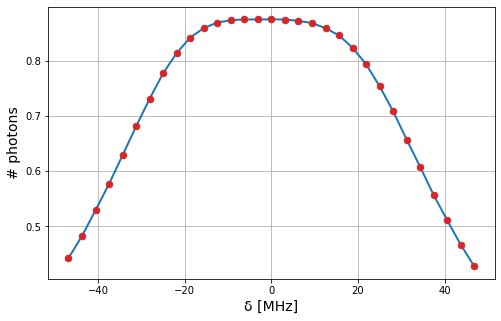

In [27]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan / (2*np.pi*1e6), results, '-', lw = 2)
ax.plot(δl_scan / (2*np.pi*1e6), results, '.', ms = 13, color = 'C3')

ax.set_xlabel("δ [MHz]", fontsize = 14)
ax.set_ylabel("# photons", fontsize = 14)
ax.grid(True)

print(f"maximum signal : {np.max(results):.2f}")

### Save Trajectory Detuning Scan Data

In [28]:
import pickle

with open(f"{transition_name}.pkl", "wb") as f:
    pickle.dump(
        dict(
            δl_scan = δl_scan,
            signal = results
        ),
        f
    )

### Fit to resonance
#### Define Gaussian and Lorentzian functions

In [29]:
from scipy.optimize import curve_fit
from scipy.special import voigt_profile

def gaussian(x, a, μ, σ):
    return a*np.exp(-(x-μ)**2 / (2*σ**2))

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def voigt(x, a, μ, σ):
    return a * voigt_profile(x - μ, σ, σ)

In [30]:
import lmfit
from lmfit.models import LorentzianModel, GaussianModel, VoigtModel

#### Fit Lorentzian to scan

In [31]:
model = LorentzianModel()
params = model.guess(
                    results, 
                    x = δl_scan
)
fit = model.fit(results, params, x = δl_scan)
print(fit.fit_report())

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 31
    # variables        = 3
    chi-square         = 0.02796026
    reduced chi-square = 9.9858e-04
    Akaike info crit   = -211.339710
    Bayesian info crit = -207.037748
##  Warning: uncertainties could not be estimated:
    center:     at initial value
[[Variables]]
    amplitude:  8.8470e+08 (init = 3.285258e+08)
    center:    -1.4192e-09 (init = -1.419158e-09)
    sigma:      3.0782e+08 (init = 1.960354e+08)
    fwhm:       6.1563e+08 == '2.0000000*sigma'
    height:     0.91485797 == '0.3183099*amplitude/max(1e-15, sigma)'


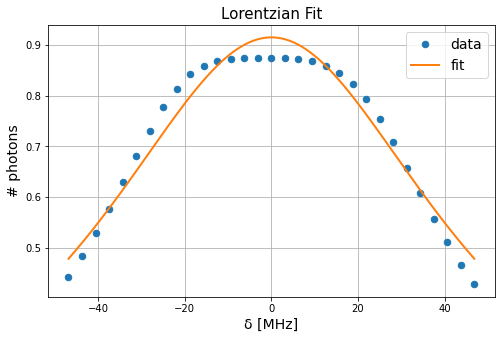

In [32]:
_x = np.linspace(δl_scan.min(), δl_scan.max(), 201)
y = fit.eval(x = _x)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan / (2*np.pi*1e6), results, '.', ms = 13, label = 'data')
ax.plot(_x / (2*np.pi*1e6), y, label = 'fit', lw = 2)

ax.set_xlabel("δ [MHz]", fontsize = 14)
ax.set_ylabel("# photons", fontsize = 14)
ax.legend(fontsize = 14)
ax.set_title("Lorentzian Fit", fontsize = 15)
ax.grid(True)

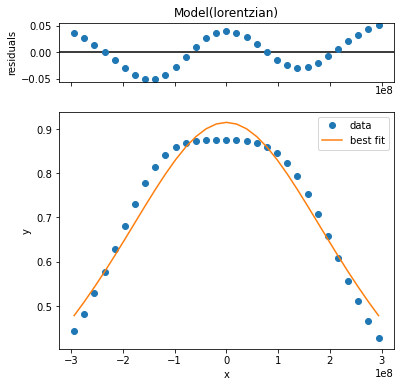

In [33]:
_ = fit.plot()

#### Fit Gaussian to scan

In [34]:
model = GaussianModel()
params = model.guess(
                    results, 
                    x = δl_scan
)
fit = model.fit(results, params, x = δl_scan)
print(fit.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 31
    # variables        = 3
    chi-square         = 0.01204432
    reduced chi-square = 4.3015e-04
    Akaike info crit   = -237.447638
    Bayesian info crit = -233.145676
##  Warning: uncertainties could not be estimated:
    center:     at initial value
[[Variables]]
    amplitude:  5.6160e+08 (init = 2.628206e+08)
    center:    -1.4192e-09 (init = -1.419158e-09)
    sigma:      2.4752e+08 (init = 1.960354e+08)
    fwhm:       5.8286e+08 == '2.3548200*sigma'
    height:     0.90516861 == '0.3989423*amplitude/max(1e-15, sigma)'


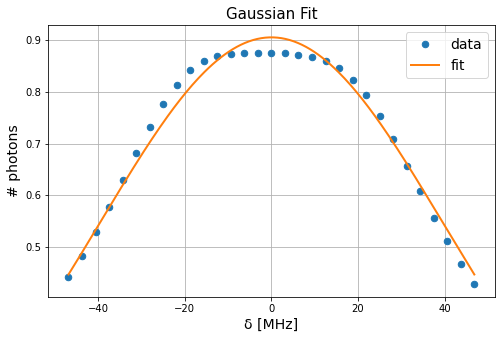

In [35]:
_x = np.linspace(δl_scan.min(), δl_scan.max(), 201)
y = fit.eval(x = _x)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan / (2*np.pi*1e6), results, '.', ms = 13, label = 'data')
ax.plot(_x / (2*np.pi*1e6), y, label = 'fit', lw = 2)

ax.set_xlabel("δ [MHz]", fontsize = 14)
ax.set_ylabel("# photons", fontsize = 14)
ax.legend(fontsize = 14)
ax.set_title("Gaussian Fit", fontsize = 15)
ax.grid(True)

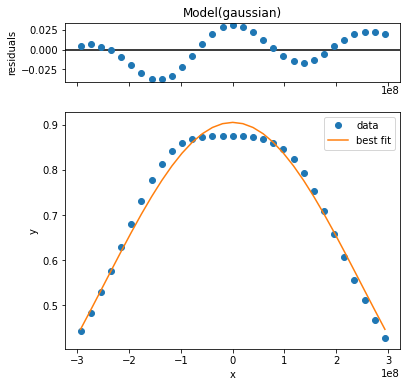

In [36]:
_ = fit.plot()

#### Fit Voigt to scan

In [37]:
model = VoigtModel()
params = model.guess(
                    results, 
                    x = δl_scan
)
fit = model.fit(results, params, x = δl_scan)
print(fit.fit_report())

[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 31
    # variables        = 3
    chi-square         = 0.01594025
    reduced chi-square = 5.6929e-04
    Akaike info crit   = -228.759754
    Bayesian info crit = -224.457793
##  Warning: uncertainties could not be estimated:
    center:     at initial value
[[Variables]]
    amplitude:  7.1508e+08 (init = 3.942309e+08)
    center:    -1.4192e-09 (init = -1.419158e-09)
    sigma:      1.6430e+08 (init = 1.27423e+08)
    gamma:      1.6430e+08 == 'sigma'
    fwhm:       5.9168e+08 == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:     0.90837760 == '(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))).real'


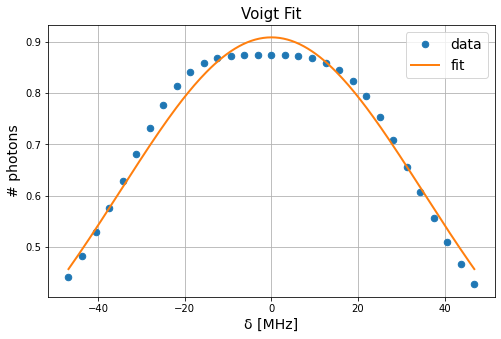

In [38]:
_x = np.linspace(δl_scan.min(), δl_scan.max(), 201)
y = fit.eval(x = _x)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan / (2*np.pi*1e6), results, '.', ms = 13, label = 'data')
ax.plot(_x / (2*np.pi*1e6), y, label = 'fit', lw = 2)

ax.set_xlabel("δ [MHz]", fontsize = 14)
ax.set_ylabel("# photons", fontsize = 14)
ax.legend(fontsize = 14)
ax.set_title("Voigt Fit", fontsize = 15)
ax.grid(True)

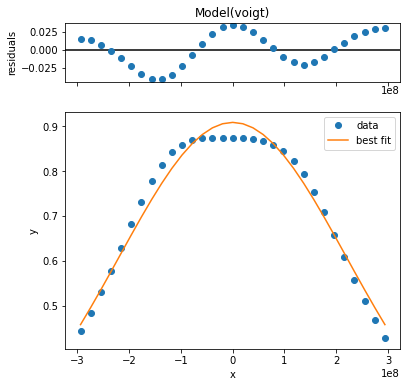

In [39]:
_ = fit.plot()